# FDS Lab S2-03: Estimation of confidence intervals with the bootstrap
**JF: That looks like a working title**
**DCS: it is - I was thinking about whether hypothesis testing would come in here too... I've alluded to it at the end**

**Learning outcomes:** In this lab you will use statistical simulations to undertake bootstrap estimation of confidence intervals. Along the way we will start to think about basic software engineering aspects of data science programming. By the end of this lab you should be able to:
- code the bootstrap estimator for a number of estimators
- validate statistical coding by comparing the output of functions with known results
- interpret the output
- compare the output with confidence intervals obtained by other methods
- think about when it makes sense to take functions out of Notebooks
We will go over simulations and randomness, from the topic on "Estimation".

In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt


# 1. Bootstrap - confidence intervals

**JF: I would add an introductory paragraph about why we are interested in confidence intervals.** 

**DCS: I am now wondering whether we should simulate estimation from a subsample of the basketball players... and then compare with the true mean**

Confidence intervals give us an indication of how sure we can be that an estimate lies within particular bounds. More precisely, we can state with a specified degree of certainty the chance that the true parameter lies in the confidence interval. For example, a 95% confidence interval has a chance of 0.95 of containing the true value. There is a trade-off between width and certainty: we can increase the width of the interval to be more certain (e.g. 99% certain).

We'll finish off what we started on the basketball data set in the previous lab. We had got to the point of generating the sample mean of samples of the age and salary. We'd now like to extend that code to generate confidence intervals for various statistics in the dataset. We'll give you the code to load the data:

In [2]:
player_data = pd.read_csv("datasets/player_data.csv")
salary_data = pd.read_csv("datasets/salary_data.csv")
full_data = pd.merge(salary_data, player_data,
                     left_on="PlayerName", right_on="Name")
full_data['Salary']=full_data['Salary']/1000000
salary_data.head()

,PlayerName,Salary
0,Kobe Bryant,23500000
1,Amar'e Stoudemire,23410988
2,Joe Johnson,23180790
3,Carmelo Anthony,22458401
4,Dwight Howard,21436271


**Exercise 01:** Using the code from last week, and the information in the lecture notes, write a bootstrap estimation routine with $k=1000$ replications to:
1. plot the sampling distribution of the mean.
2. find a 95% confidence interval for the mean of the salary data.

Confidence interval
0.025    3.85299
0.975    4.70770
dtype: float64


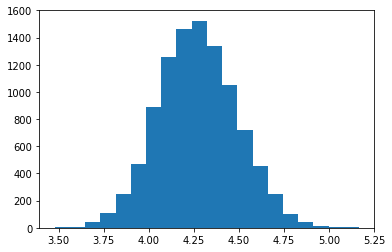

In [3]:
# Your code
salaries = full_data['Salary']
k = 10000
n = len(salary_data)

x_star_tilde = np.zeros(k)
for i in range(k):
    x_star = salaries.sample(n, replace=True)
    x_star_tilde[i] = x_star.mean()
    
    
plt.hist(x_star_tilde, 20)
print("Confidence interval")
print(pd.Series(x_star_tilde).quantile([0.025, 0.975]))

## Engineering a bootstrap function

Later on in the lab, we are going to apply the bootstrap to a different estimator, and also run it repeatedly. We'd therefore like to turn it into a function.

**Exercise 02:**  **JF: I think by now they should know why we write functions. I would rather write a sentence about why we need this specific functions.** **DCS: fair enough: see above**. Write a function called bootstrap(), which takes as its input arguments:
1. `x`: pd.Series()
3. `estimator`: The function (e.g. `np.mean`) that you would like to get the bootstrap confidence intervals for. Note that you can pass functions as arguments to python functions.
4. `quantiles`: An array containing the desired quantiles
5. `plot`: Boolean indicating if a plot of the bootstrap distribution of the estimator should be shown. `False` by default.
 
It should return:
1. the quantiles
2. the bootstrap standard deviation

0.2183268835510915


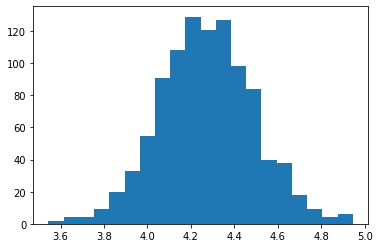

In [4]:
def bootstrap(x, k=1000, estimator=np.mean, quantiles=[0.025, 0.975], plot=False):
    n = len(x)
    x_star_est = np.zeros(k)
    for i in range(k):
        x_star = np.random.choice(x, n, replace=True)
        x_star_est[i] = estimator(x_star)
        
    if (plot):
        plt.hist(x_star_est, 20)
    return(np.quantile(x_star_est, quantiles), np.std(x_star_est))

ci, std = bootstrap(salaries, plot=True)
print(std)

## Testing the function

When you want to deploy code you should always check that each function actually does what it is supposed to do. A good habit is to do what is called *unit testing* -  a method by which units of the code are checked for correctness. These are typically short code snippets that check automatically that the output of a function is as intended. In our setting, however, this would be an overkill, and we can just check manually whether our function has the correct output on a known setting. In this, artificial, case we know the distribution, so we can estimate the SEM as $\sigma_{\overline{X}} = \sigma/\sqrt{n}$ . 

**Exercise 03:** 
- Compare the SEM computed from the full distribution with the bootstrap estimates.
- Are they of a similar size? If so, good - if not, go back and check the bootstrap function.
- Compare the quantiles produced by the function with the distribution produced with `plot=True`. Do the quantiles lie in the distribution?

0.2149839356734121 0.215521919499658 [3.84763868 4.67963109]


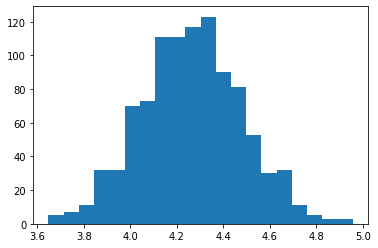

In [5]:
SEM = np.std(salaries)/np.sqrt(len(salaries))
ci, std = bootstrap(salaries, plot=True)
print(SEM, std, quantiles)

Your answer:
    
The SEM of the distribution and the estimated SEM computed from the bootstrap estimator are similar. The quantiles look about right too, compared to the distribution.

## Apply the bootstrap function to the median

**JF: Do we need a title here? It's exactly the same as the exercise**. **DCS: Maybe not - but there is the discussion below**.

**Exercise 05:** Apply your new bootstrap function to the confidence intervals of the median of the salaries, plotting the distribution.

(array([2.       , 2.8839045]), 0.2424898748532323)

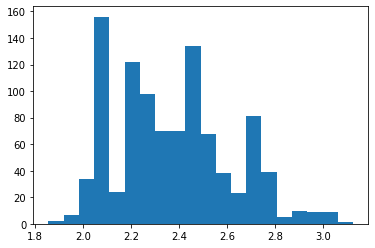

In [6]:
bootstrap(salaries, 1000, estimator=np.median, plot=True)

**Discussion:** Does the distribution of the sample median look as you would expect it to? If not, what is unusual about it? Can you explain why you're seeing this?

Your answer:
    
The bootstrap distribution does not look as I expected it to. It looks bumpy. This is probably because there are some very common exact amounts of salaries, meaning the median gets stuck there.

In [7]:
x_star_tilde

array([4.02111839, 3.98408083, 4.18901024, ..., 4.2062073 , 4.07228751,
       4.19066813])

## Comparing the confidence interval to the theoretical value

**Exercise 07:** Use the theoretical method of determining the confidence interval, assuming a normal distribution of mean.

# 2. Bootstrap applied to linear regression -  output from other packages

As we've said in the lectures, we can apply the bootstrap estimator to many different types of statistic, where by "statistic" we mean a value derived from the data. Linear regression coefficients also count as statistics - so we should be able to used the bootstrap on them.
 
 **Exercise 06:** 
 - Create a new column of `full_data` called `LogSalary`, which is the log to the base 10 of `Salary`.
 - Plot the `LogSalary` against the `Age`.
 - Fit a linear regression of the `LogSalary` to the `Age` using `statsmodels`. (See the linear regression lab).
 - Extract the best fitting Intercept and Age parameters from the result

In [8]:
import seaborn as sns
import statsmodels.formula.api as smf
# sns.pairplot(full_data)

In [9]:
full_data['LogSalary'] = np.log10(full_data['Salary'])

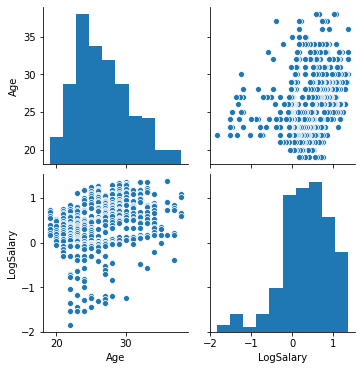

In [10]:
sns.pairplot(full_data, vars=['Age', 'LogSalary'])

In [11]:
## Maybe we should give this?
model = smf.ols('LogSalary ~ Age', data=full_data)
results = model.fit()
results.params

Intercept   -0.797333
Age          0.042749
dtype: float64

**Exercise 07:** Now use the code to write a function `beta0hat` that, given a data frame `df` with the same format as `full_data` returns the fitted intercept. Test that it gets the correct results, when given full_data as an argument.

In [12]:
def beta0hat(dat):
    model = smf.ols('LogSalary ~ Age', data=dat)
    results = model.fit()
    return(results.params['Intercept'])

beta0hat(full_data)

-0.7973333757451672

**Exercise 08:** 
- Write a function `bootstrap_df`, which is the same as `bootstrap`, but in which the estimator can take a DataFrame as an argument, and return a statistic (i.e., just like the function `beta0hat` does).
- Write a function `salary_mean()` that returns the mean of the `Salary` column of a data frame, and use it to verify that `bootstrap_df` gives similar results to the ones you obtained above.

In [13]:
def bootstrap_df(x, k=1000, estimator=np.mean, quantiles=[0.025, 0.975], plot=False):
    n = len(x)
    x_star_est = np.zeros(k)
    for i in range(k):
        x_star = x.sample(n, replace=True)
        x_star_est[i] = estimator(x_star)
        
    if (plot):
        plt.hist(x_star_est, 20)
    return(np.quantile(x_star_est, quantiles), np.std(x_star_est))

def salary_mean(dat):
    return(dat['Salary'].mean())

bootstrap_df(full_data, estimator=salary_mean)

(array([3.87266924, 4.67608868]), 0.2063975701592905)

**Exercise 09:**
Now apply the `bootstrap_df` function to get confidence intervals of the `Intercept` of the linear regression of `Age` on `LogSalary`.

In [14]:
bootstrap_df(full_data, estimator=beta0hat)

(array([-1.07612042, -0.51676629]), 0.14450285004659671)

**Discussion:** Does the confidence interval contain the value of estimated `Intercept`?

**Exercise 10:** Create a function `beta1hat` that returns the fitted slope (`Age`) parameter. Apply `boodstrap_df` to it to return confidence interval and standard error in the estimator.

In [15]:
def beta1hat(dat):
    model = smf.ols('LogSalary ~ Age', data=dat)
    results = model.fit()
    return(results.params['Age'])

bootstrap_df(full_data, estimator=beta1hat)

(array([0.0324702 , 0.05350663]), 0.005284761050790477)

# 3 Comparison of bootstrap and theoretical confidence interval

In this example, we don't actually have to use the bootstrap to estimate the confidence intervals; statsmodels (and many other packages) can estimate the standard error of the sampling distribution of the estimator. Run the statsmodels fit again, but this time report all the output using the `summary`.

In [16]:
## Maybe we should give this?
model = smf.ols('LogSalary ~ Age', data=full_data)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              LogSalary   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     51.14
Date:                Thu, 21 Jan 2021   Prob (F-statistic):           3.15e-12
Time:                        14:39:47   Log-Likelihood:                -407.87
No. Observations:                 492   AIC:                             819.7
Df Residuals:                     490   BIC:                             828.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7973      0.161     -4.965      0.000      -1.113      -0.482
Age            0.0427      0.006      7.151      0.000       0.031       0.054
==============================================================================
Omnibus:                       58.598   Durbin-Watson:                   0.147
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.073
Skew:                          -0.838   Prob(JB):                     1.51e-18
Kurtosis:                       4.094   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Look at the middle table of the results, containing the `Intercept` and `Age` variables. In semester 1 we learned how to interpret the `coeff` column. We should now be able to understand the `std err` and `[0.025` and `0.975]` columns. 
- `coeff`: best estimate of `Intercept` and `Age`
- `std err`: the standard error of the estimators of `Intercept` and `Age`
- `[0.025`: lower bound of the 95% confidence interval of the estimators of `Intercept` and `Age`
- `0.025]`: upper bound of the 95% confidence interval of the estimators of `Intercept` and `Age`

**Discussion**:
- Are the standard errors reported here close to the bootstrap estimates? 
- Are the confidence intervals close to the bootstrap estimates?
- Is the number 0 contained in either of the 95% confidence intervals?

Your answer

- Yes the standard errors are close
- Yes the confidence intervals are close
- No, the number 0 is not contained in either of the confidence intervals

**Explanation:** The `t` column refers to the `t` statistic: 

$t = \frac{\hat\theta - 0}{\hat\sigma_{\hat\theta}}$

You can check that `t` does indeed equal the coefficient divided by the standard error.

It has to do with a hypothesis test. The null and alternative hypotheses are:

$H_0$: The true value of the parameter is equal to zero

$H_\mathrm{a}$: The parameter is equal to something else

Due to the duality between confidence intervals and hypothesis testing, to test the null hypothesis we can consider the area in the tail of the sampling distribution beyond 0 to be the *p*-value. In the case of both the Age and the Salary, this *p*-value `P>|t|` is 0.  